In [88]:
from RBF_exosceleton.obj_io import *
import numpy as np
import math

In [89]:
DEFORMATION_INPUT = 'tetr_1.obj'
DEFORMATION_BASIS_FROM = 'tetr_1.obj'
DEFORMATION_BASIS_TO = 'tetr_1_rotated_z_10.obj'

In [90]:
f = open(DEFORMATION_INPUT, 'r')
di = f.read()
f.close()
di_vs = vertexes(di)
di_ts = triangles(di)

f = open(DEFORMATION_BASIS_FROM, 'r')
dbf = f.read()
f.close()
dbf_vs = vertexes(dbf)
dbf_ts = triangles(dbf)

f = open(DEFORMATION_BASIS_TO, 'r')
dbt = f.read()
f.close()
dbt_vs = vertexes(dbt)
dbt_ts = triangles(dbt)

print('low-polygonal models:\n\tdeformation basis from has', len(dbf_ts), 'triangles and \n\tdeformation basis to has', len(dbt_ts), 'triangles.\n')

def get_triangle_point(vertexes, triangleIndx):
    return np.array([vertexes[triangleIndx - 1][0],
                    vertexes[triangleIndx - 1][1],
                    vertexes[triangleIndx - 1][2]])


low-polygonal models:
	deformation basis from has 4 triangles and 
	deformation basis to has 4 triangles.



In [91]:
print("di_vertexes", di_vs)
print("di_triangles", di_ts)
for tri, i in zip(di_ts, range(0, len(di_ts))):
    #to_point_str = lambda tri, i: f"[{di_vs[tri[i] - 1][0]}, {di_vs[tri[i] - 1][1]}, {di_vs[tri[i] - 1][2]}]"
    print(f"Triangle {i}: {tri} :: [{get_triangle_point(di_vs, tri[0])}, {get_triangle_point(di_vs, tri[1])}, {get_triangle_point(di_vs, tri[2])}]")

di_vertexes [[10.0, 50.0, 10.0], [10.0, 10.0, 50.0], [10.0, 10.0, 10.0], [49.7488, 10.0, 10.0]]
di_triangles [[1, 2, 3], [1, 4, 2], [4, 1, 3], [2, 4, 3]]
Triangle 0: [1, 2, 3] :: [[10. 50. 10.], [10. 10. 50.], [10. 10. 10.]]
Triangle 1: [1, 4, 2] :: [[10. 50. 10.], [49.7488 10.     10.    ], [10. 10. 50.]]
Triangle 2: [4, 1, 3] :: [[49.7488 10.     10.    ], [10. 50. 10.], [10. 10. 10.]]
Triangle 3: [2, 4, 3] :: [[10. 10. 50.], [49.7488 10.     10.    ], [10. 10. 10.]]


Plain equestion:
\begin{vmatrix}
x - x_1 & y - y_1 & z - z_1 \\
x_2 - x_1 & y_2 - y_1 & z_2 - z_1 \\
x_3 - x_1 & y_3 - y_1 & z_3 - z_1
\end{vmatrix} = 0

---
https://brilliant.org/wiki/3d-coordinate-geometry-equation-of-a-plane/
```math
point\ P = (x_1, y_1, z_1) \\
\vec{n} = (a, b, c)\\
a(x - x_1) + b(y - y_1) + c(z - z_1) = 0 \\
---------------- \\
Ax + Bx + Cz + D = 0 \\
D = -(Ax_0 + By_0 + Cz_0)
```
https://stackoverflow.com/questions/36060933/plot-a-plane-and-points-in-3d-simultaneously
```math
z = (\vec{a}*\vec{n} - Ax - By) / C
```


A,B,C we can find:

```math
A = (y_2 - y_1)(z_3 - z_1) - (z_2 - z_1)(y_3 - y_1) \\
B = (z_2 - z_1)(x_3 - x_1) - (x_2 - x_1)(z_3 - z_1) \\
C = (x_2 - x_1)(y_3 - y_1) - (y_2 - y_1)(x_3 - x_1)
```

In [92]:
class Plane:
	A = -1
	B = -1
	C = -1
	D = -1

	P1 = np.array([-1, -1, -1])
	P2 = np.array([-1, -1, -1])
	P3 = np.array([-1, -1, -1])

	@staticmethod
	def from_abcd(a, b, c, d):
		p = Plane()
		p.A, p.B, p.C, p.D = a, b, c, d
		return p

	def __init__(self, p1 = np.array([-1, -1, -1]), p2 = np.array([-1, -1, -1]), p3 = np.array([-1, -1, -1])):
		self.P1, self.P2, self.P3 = p1, p2, p3

		# Calculate two vectors in the plane
		p2p1 = p2 - p1
		p3p1 = p3 - p1

		# Calculate the normal vector to the plane using the cross product
		normal_vector = np.cross(p2p1, p3p1)
		
		# Get plane coefficients
		self.A, self.B, self.C = normal_vector

		# Calculate the value of D for the plane equation ax + by + cz + d = 0
		self.D = -(self.A * p1[0] + self.B * p1[1] + self.C * p1[2])

	def get_surface_for_z(self, X, Y): # X, Y: 2D arrays (2D grid)
		return (-self.A * X - self.B * Y - self.D) / self.C
 
	def length(self):
		# magnitude of the normal vector
		return math.sqrt(self.A ** 2 + self.B ** 2 + self.C ** 2)

	def normalized(self):
		magnitude = self.length()
		if magnitude == 0:
			return self
		else:
			return Plane.from_abcd(self.A / magnitude, self.B / magnitude, self.C / magnitude, self.D / magnitude)

	def sign_distance(self, point):
		assert(self.length() == 1)
		x, y, z = point
		return self.A * x + self.B * y + self.C * z + self.D

	def __str__(self):
		return f"Plane(A={self.A}; B={self.B}; C={self.C}; D={self.D})"

In [93]:
planes:list[Plane] = []

for tri in di_ts:
	p1 = get_triangle_point(di_vs, tri[0])
	p2 = get_triangle_point(di_vs, tri[1])
	p3 = get_triangle_point(di_vs, tri[2])
	planes.append(Plane(p1, p2, p3))
	#print(planes[-1])

planes: 4


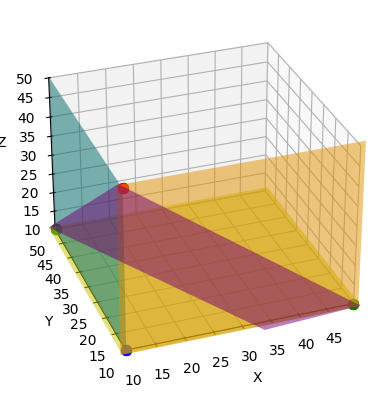

In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a list of colors to cycle through for each plane
colors = ['cyan', 'magenta', 'yellow', 'orange', 'purple', 'green', 'blue']

print("planes:", len(planes))

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

######################################################
# Collect all points to determine the maximum range across axes
all_points = []
for plane in planes:
    all_points.extend([plane.P1, plane.P2, plane.P3])

all_points = np.array(all_points)
max_range = np.array([all_points[:, 0].max() - all_points[:, 0].min(),
                      all_points[:, 1].max() - all_points[:, 1].min(),
                      all_points[:, 2].max() - all_points[:, 2].min()]).max() / 2.0

mid_x = (all_points[:, 0].max() + all_points[:, 0].min()) * 0.5
mid_y = (all_points[:, 1].max() + all_points[:, 1].min()) * 0.5
mid_z = (all_points[:, 2].max() + all_points[:, 2].min()) * 0.5

# Set equal scaling for the axes
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)
######################################################

for idx, plane in enumerate(planes):
	if (plane.C == 0 and plane.B == 0) and plane.A != 0:
		x_value = -plane.D / plane.A  # x is constant
		y_range = np.linspace(mid_y - max_range, mid_y + max_range, 10)
		z_range = np.linspace(mid_z - max_range, mid_z + max_range, 10)
		Y, Z = np.meshgrid(y_range, z_range)
		X = np.full(Y.shape, x_value)  # Set X to the constant value

	elif plane.C == 0 and plane.B != 0:
		# Define Z range instead and solve for Y
		x_range = np.linspace(min(plane.P1[0], plane.P2[0], plane.P3[0]) - 1, max(plane.P1[0], plane.P2[0], plane.P3[0]) + 1, 10)
		z_range = np.linspace(min(plane.P1[2], plane.P2[2], plane.P3[2]) - 1, max(plane.P1[2], plane.P2[2], plane.P3[2]) + 1, 10)
		X, Z = np.meshgrid(x_range, z_range)
		Y = (-plane.A * X - plane.C * Z - plane.D) / plane.B

	else:
		x_range = np.linspace(min(plane.P1[0], plane.P2[0], plane.P3[0]) - 1, max(plane.P1[0], plane.P2[0], plane.P3[0]) + 1, 10)
		y_range = np.linspace(min(plane.P1[1], plane.P2[1], plane.P3[1]) - 1, max(plane.P1[1], plane.P2[1], plane.P3[1]) + 1, 10)
		X, Y = np.meshgrid(x_range, y_range)
		Z = (-plane.A * X - plane.B * Y - plane.D) / plane.C

	color = colors[idx % len(colors)]
	ax.plot_surface(X, Y, Z, color=color, alpha=0.5, rstride=100, cstride=100, label=f"Plane {idx+1}")

	ax.scatter(*plane.P1, color='red', s=50, label="P1")
	ax.scatter(*plane.P2, color='green', s=50, label="P2")
	ax.scatter(*plane.P3, color='blue', s=50, label="P3")

# Rotate the plot by 90 degrees (adjust as needed)
ax.view_init(elev=30, azim=-110, roll=0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.legend()

plt.show()

In [109]:
def get_polypoint_plane(plane: Plane, orig_basises: list, res_basises: list):
	# print("plane", plane, plane.length())
	plane = plane.normalized()
	# print("normalized plane", plane)

	a1, b1, c1, d1, r1 = 0, 0, 0, 0, 0
	a2, b2, c2, d2, r2 = 0, 0, 0, 0, 0
	a3, b3, c3, d3, r3 = 0, 0, 0, 0, 0
	a4, b4, c4, d4, r4 = 0, 0, 0, 0, 0

	for orig_basis_p, res_basis_p in zip(orig_basises, res_basises):
		orig_basis_p = np.array(orig_basis_p)
		res_basis_p = np.array(res_basis_p)

		γ = plane.sign_distance(orig_basis_p)
		# print("orig_basis_p", orig_basis_p, "\t γ", γ)

		x = res_basis_p[0]
		y = res_basis_p[1]
		z = res_basis_p[2]
		h = 1 # ???

		a1 += x * x
		b1 += x * y
		c1 += x * z
		d1 += x * h
		r1 += x * γ

		a2 += y * x
		b2 += y * y
		c2 += y * z
		d2 += y * h
		r2 += y * γ

		a3 += z * x
		b3 += z * y
		c3 += z * z
		d3 += z * h
		r3 += z * γ

		a4 += h * x
		b4 += h * y
		c4 += h * z
		d4 += h * h
		r4 += h * γ

	# Add a small regularization term to the diagonal elements of A
	reg_term = 1e-10
	A = np.array([
		[a1 + reg_term, b1, c1, d1],
		[b1, b2 + reg_term, c2, d2],
		[c1, c2, c3 + reg_term, d3],
		[d1, d2, d3, d4 + reg_term]])

	B = np.array([r1, r2, r3, r4])
	X = np.linalg.solve(A, B)
	return Plane.from_abcd(X[0], X[1], X[2], X[3])


In [112]:


orig_basises = [[-1, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, -1.0], [0.0, 0.0, 1.0]]
res_basises = [[-1, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, -1.0], [0.0, 0.0, 1.0]]

tr_planes:list[Plane] = []
for plane in planes:
	tr_planes.append(get_polypoint_plane(plane, orig_basises, res_basises))

for plane, tr_plane in zip(planes, tr_planes):
	print("in :", plane.normalized())
	print("Out:", tr_plane.normalized(), "\n")

in : Plane(A=1.0; B=0.0; C=0.0; D=-10.0)
Out: Plane(A=1.0; B=-4.5000092520908586e-10; C=0.0; D=-9.99999999604999) 

in : Plane(A=-0.5797750427595797; B=-0.5761340554910496; C=-0.5761340554910496; D=40.365793757058775)
Out: Plane(A=-0.5797750447638038; B=-0.5761340534591488; C=-0.5761340555060602; D=40.3657937581109) 

in : Plane(A=0.0; B=0.0; C=1.0; D=-10.0)
Out: Plane(A=5.000000413451855e-10; B=-5.000000413451855e-10; C=1.0; D=-10.0) 

in : Plane(A=0.0; B=1.0; C=0.0; D=-10.0)
Out: Plane(A=5.500009339881248e-10; B=1.0; C=0.0; D=-10.000000005950008) 



planes: 4


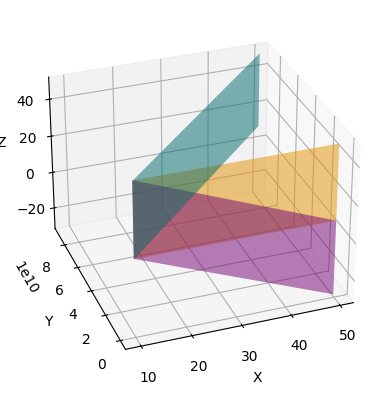

In [113]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a list of colors to cycle through for each plane
colors = ['cyan', 'magenta', 'yellow', 'orange', 'purple', 'green', 'blue']

print("planes:", len(tr_planes))

# Plotting
fig = plt.figure()
ax: Axes3D = fig.add_subplot(111, projection='3d')

	#x_range = np.linspace(mid_x - max_range, mid_x + max_range, 10)
	#y_range = np.linspace(mid_y - max_range, mid_y + max_range, 10)
	#z_range = np.linspace(mid_z - max_range, mid_z + max_range, 10)
	
for idx, plane in enumerate(tr_planes):
	#x_range = np.linspace(mid_x - max_range, mid_x + max_range, 10)
	#y_range = np.linspace(mid_y - max_range, mid_y + max_range, 10)
	#z_range = np.linspace(mid_z - max_range, mid_z + max_range, 10)

	if (plane.C == 0 and plane.B == 0) and plane.A != 0:
		x_value = -plane.D / plane.A  # x is constant
		Y, Z = np.meshgrid(y_range, z_range)
		X = np.full(Y.shape, x_value)  # Set X to the constant value

	elif plane.C == 0 and plane.B != 0:
		# Define Z range instead and solve for Y
		X, Z = np.meshgrid(x_range, z_range)
		Y = (-plane.A * X - plane.C * Z - plane.D) / plane.B

	else:
		X, Y = np.meshgrid(x_range, y_range)
		Z = (-plane.A * X - plane.B * Y - plane.D) / plane.C

	color = colors[idx % len(colors)]
	ax.plot_surface(X, Y, Z, color=color, alpha=0.5, rstride=100, cstride=100, label=f"Plane {idx+1}")

# Rotate the plot by 90 degrees (adjust as needed)
ax.view_init(elev=30, azim=-110, roll=0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.legend()

plt.show()